## **Import Libraris**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import time
import warnings
warnings.filterwarnings('ignore')

import opendatasets as od

from keras.applications.xception import Xception
from keras.models import Model
from keras.layers import Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy

## **Download The Dataset**

In [2]:
od.download('https://www.kaggle.com/datasets/dineshpiyasamara/cats-and-dogs-for-classification')

Skipping, found downloaded files in "./cats-and-dogs-for-classification" (use force=True to force download)


In [3]:
batch_size = 32
image_size = (128, 128)

## **Load Dataset**

In [4]:
train_data_dir = "/content/cats-and-dogs-for-classification/cats_dogs/train"
test_data_dir = "/content/cats-and-dogs-for-classification/cats_dogs/test"

## **Split Dataset Into Train Test And Validation**

In [5]:
train_data = tf.keras.utils.image_dataset_from_directory(train_data_dir,
                                                       batch_size=batch_size,
                                                       image_size=image_size,
                                                       subset="training",
                                                       validation_split=0.1,
                                                       seed=42)

validation_data = tf.keras.utils.image_dataset_from_directory(train_data_dir,
                                                              batch_size=batch_size,
                                                              image_size=image_size,
                                                              subset="validation",
                                                              validation_split=0.1,
                                                              seed=42)

test_data = tf.keras.utils.image_dataset_from_directory(test_data_dir,
                                                       batch_size=batch_size,
                                                       image_size=image_size)

Found 8000 files belonging to 2 classes.
Using 7200 files for training.
Found 8000 files belonging to 2 classes.
Using 800 files for validation.
Found 2000 files belonging to 2 classes.


In [6]:
class_names = train_data.class_names
print(class_names)

['cats', 'dogs']


In [7]:
for image_batch, label_batch in train_data.take(1):
  print(image_batch.shape)
  print(label_batch.shape)

(32, 128, 128, 3)
(32,)


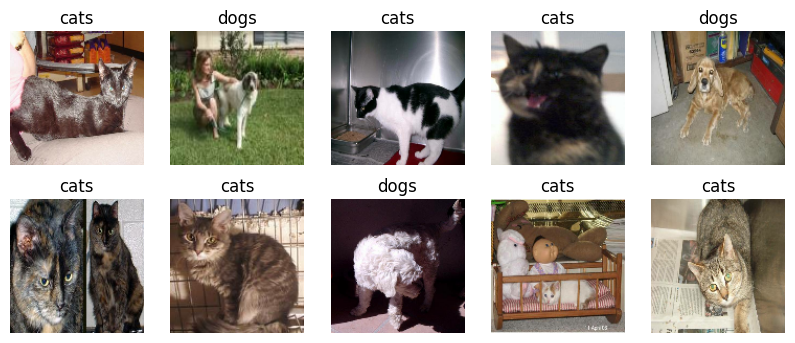

In [8]:
plt.figure(figsize=(10,4))

for image, label in train_data.take(1):
  for i in range(10):
    ax = plt.subplot(2, 5, i+1)
    plt.imshow(image[i].numpy().astype("uint8"))
    plt.title(class_names[label[i]])
    plt.axis("off")

## **Data Preprocessing**

### **Feature Scaling (Normalization)**

In [9]:
# See an one images details
for image, label in train_data.take(1):
  for i in range(1):
    print(image)

tf.Tensor(
[[[[101.00769   104.00769   109.00769  ]
   [111.074585  112.71521   114.30505  ]
   [117.635284  115.31354   112.59396  ]
   ...
   [129.86246   132.91324   136.22964  ]
   [126.8725    133.10297   135.69281  ]
   [128.9002    138.99207   139.94614  ]]

  [[ 85.20029    88.20029    93.20029  ]
   [ 99.3725     99.79227   101.78906  ]
   [114.00287   112.997925  110.048706 ]
   ...
   [116.720825  120.720825  123.720825 ]
   [119.9389    126.16937   128.75922  ]
   [138.79547   147.0824    148.93893  ]]

  [[ 92.54297    94.90234    99.58203  ]
   [ 91.57605    91.986206   93.986206 ]
   [105.38388   104.38388   101.75107  ]
   ...
   [120.73743   125.52237   128.52237  ]
   [130.21445   135.21445   138.21445  ]
   [127.32648   134.36554   136.68585  ]]

  ...

  [[118.07504   122.07504   125.07504  ]
   [121.617584  125.617584  128.61758  ]
   [130.54602   134.54602   137.54602  ]
   ...
   [ 81.51825    87.02301    96.76108  ]
   [ 45.951294   50.819916   54.147003 ]
   [ 

In [10]:
train_data = train_data.map(lambda x,y: (x/255.0, y))
validation_data = validation_data.map(lambda x,y: (x/255.0, y))
test_data = test_data.map(lambda x,y: (x/255.0 , y))

In [11]:
for image, label in train_data.take(1):
  for i in range(1):
    print(image)

tf.Tensor(
[[[[0.15117954 0.08451287 0.12372855]
   [0.1564951  0.08982843 0.12904412]
   [0.14387254 0.07720588 0.11642157]
   ...
   [0.         0.00392157 0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  [[0.15078124 0.08411458 0.12333027]
   [0.1463848  0.07971814 0.11893383]
   [0.13852635 0.07185968 0.11107536]
   ...
   [0.         0.         0.        ]
   [0.         0.00127145 0.        ]
   [0.         0.         0.        ]]

  [[0.15681386 0.09014719 0.12936288]
   [0.15010071 0.08343404 0.12264973]
   [0.1491728  0.08250613 0.12172181]
   ...
   [0.00392157 0.         0.        ]
   [0.         0.00392157 0.        ]
   [0.         0.         0.        ]]

  ...

  [[0.7237403  0.6738876  0.726761  ]
   [0.7528033  0.7035823  0.75956535]
   [0.77319306 0.71951526 0.7698836 ]
   ...
   [0.04705882 0.00392157 0.03529412]
   [0.05098039 0.         0.03529412]
   [0.0395804  0.         0.03137255]]

  [[0.7596398  0.66668636 0.694030

### **Data Augmentation**

In [12]:
datagen = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical", input_shape=(128, 128, 3)),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
])

## **Transfer Learning ( Xception CNN)**

In [13]:
baseModel = Xception(include_top=False, input_shape=(128, 128, 3), weights="imagenet", pooling="max")

headModel = baseModel.output

headModel = Flatten()(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(32, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(1, activation="sigmoid")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
  layer.trainable = False

model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=["accuracy"])

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 63, 63, 32)           864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 63, 63, 32)           128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 63, 63, 32)           0         ['block1_conv1_bn[0][0]'] 

In [15]:
start_time = time.time()

history = model.fit(train_data, epochs=20, validation_data=validation_data)

end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed time:", elapsed_time)

Epoch 1/20
225/225 [==============================] - 24s 63ms/step - loss: 0.3581 - accuracy: 0.8625 - val_loss: 0.1170 - val_accuracy: 0.9463
Epoch 2/20
225/225 [==============================] - 14s 61ms/step - loss: 0.1999 - accuracy: 0.9265 - val_loss: 0.1176 - val_accuracy: 0.9538
Epoch 3/20
225/225 [==============================] - 12s 54ms/step - loss: 0.1726 - accuracy: 0.9342 - val_loss: 0.1068 - val_accuracy: 0.9600
Epoch 4/20
225/225 [==============================] - 13s 57ms/step - loss: 0.1509 - accuracy: 0.9433 - val_loss: 0.0923 - val_accuracy: 0.9600
Epoch 5/20
225/225 [==============================] - 13s 57ms/step - loss: 0.1343 - accuracy: 0.9478 - val_loss: 0.1014 - val_accuracy: 0.9638
Epoch 6/20
225/225 [==============================] - 12s 54ms/step - loss: 0.1349 - accuracy: 0.9513 - val_loss: 0.1034 - val_accuracy: 0.9588
Epoch 7/20
225/225 [==============================] - 12s 54ms/step - loss: 0.1310 - accuracy: 0.9503 - val_loss: 0.1084 - val_accuracy:

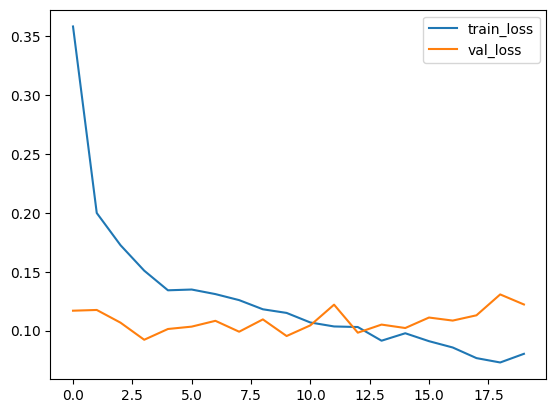

In [16]:
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()
plt.show()

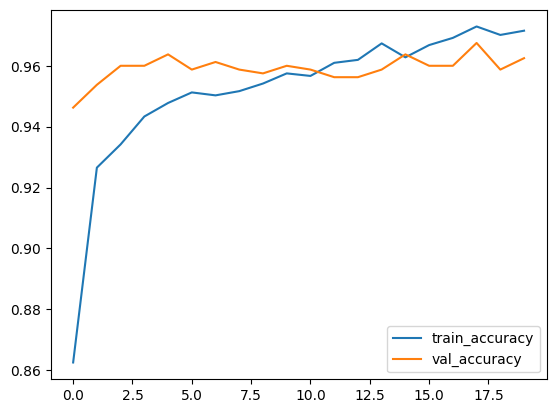

In [17]:
plt.plot(history.history["accuracy"], label="train_accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.legend()
plt.show()

## **Model Evaluation**

In [20]:
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
accuracy = tf.keras.metrics.BinaryAccuracy()

In [22]:
for batch in test_data.as_numpy_iterator():
  images, labels = batch
  y_pred = model.predict(images)
  precision.update_state(labels, y_pred)
  recall.update_state(labels, y_pred)
  accuracy.update_state(labels, y_pred)

1/1 [==============================] - 2s 2s/step


In [23]:
print(precision.result())
print(recall.result())
print(accuracy.result())

tf.Tensor(0.9522863, shape=(), dtype=float32)
tf.Tensor(0.958, shape=(), dtype=float32)
tf.Tensor(0.955, shape=(), dtype=float32)


## **Predictions Pypline**

In [24]:
import cv2

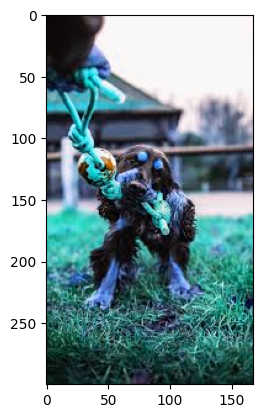

In [42]:
img = cv2.imread("/content/images.jpg")
plt.imshow(img)
plt.show()

In [43]:
# Normalization
img_resized = cv2.resize(img, image_size)
img_scaled = img_resized/255.0
img_scaled

array([[[0.05098039, 0.03137255, 0.02745098],
        [0.05098039, 0.03137255, 0.02745098],
        [0.05098039, 0.03137255, 0.02745098],
        ...,
        [0.98823529, 0.96862745, 0.96470588],
        [0.98823529, 0.96862745, 0.96470588],
        [0.98823529, 0.96862745, 0.96470588]],

       [[0.05098039, 0.03137255, 0.02745098],
        [0.05098039, 0.03137255, 0.02745098],
        [0.05098039, 0.03137255, 0.02745098],
        ...,
        [0.98823529, 0.96862745, 0.96470588],
        [0.98823529, 0.96862745, 0.96470588],
        [0.98823529, 0.96862745, 0.96470588]],

       [[0.05098039, 0.03137255, 0.02745098],
        [0.05098039, 0.03137255, 0.02745098],
        [0.05098039, 0.03137255, 0.02745098],
        ...,
        [0.98823529, 0.96862745, 0.96470588],
        [0.98823529, 0.96862745, 0.96470588],
        [0.98823529, 0.96862745, 0.96470588]],

       ...,

       [[0.07843137, 0.13333333, 0.11764706],
        [0.0745098 , 0.13333333, 0.11764706],
        [0.07058824, 0

In [44]:
# make shape
img_reshaped = np.expand_dims(img_scaled, axis=0)
img_reshaped

array([[[[0.05098039, 0.03137255, 0.02745098],
         [0.05098039, 0.03137255, 0.02745098],
         [0.05098039, 0.03137255, 0.02745098],
         ...,
         [0.98823529, 0.96862745, 0.96470588],
         [0.98823529, 0.96862745, 0.96470588],
         [0.98823529, 0.96862745, 0.96470588]],

        [[0.05098039, 0.03137255, 0.02745098],
         [0.05098039, 0.03137255, 0.02745098],
         [0.05098039, 0.03137255, 0.02745098],
         ...,
         [0.98823529, 0.96862745, 0.96470588],
         [0.98823529, 0.96862745, 0.96470588],
         [0.98823529, 0.96862745, 0.96470588]],

        [[0.05098039, 0.03137255, 0.02745098],
         [0.05098039, 0.03137255, 0.02745098],
         [0.05098039, 0.03137255, 0.02745098],
         ...,
         [0.98823529, 0.96862745, 0.96470588],
         [0.98823529, 0.96862745, 0.96470588],
         [0.98823529, 0.96862745, 0.96470588]],

        ...,

        [[0.07843137, 0.13333333, 0.11764706],
         [0.0745098 , 0.13333333, 0.11764706]

In [45]:
y_pred = model.predict(img_reshaped)
y_pred

1/1 [==============================] - 0s 22ms/step


array([[0.9194331]], dtype=float32)

In [46]:
class_names

['cats', 'dogs']

In [47]:
if y_pred >= 0.5:
  print(f"{class_names[1]} Dog")
else:
  print(f"{class_names[0]} Cat")

dogs Dog
